# Training

In [1]:
# -*- coding:utf-8 -*-
import os
import pickle
import numpy as np
from math import exp
from numpy import array
from skimage.color import rgb2ycbcr
from skimage.color import ycbcr2rgb
from skimage.measure import compare_psnr
from skimage.measure import compare_ssim
from scipy.signal import medfilt
from scipy.signal import convolve2d as conv2
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize
from scipy.signal import convolve
from skimage.util import view_as_windows
import  skimage.io as io
from skimage import data_dir
from sklearn.decomposition import dict_learning_online
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import sparse_encode
from scipy.io import loadmat
from scipy.io import savemat
from scipy import sparse as sps
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from math import log
from itertools import product
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import copy

set the parameters

In [3]:
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [4]:
def get_PCA(x):
    '''
    x in shape of (n_samples, n_features)
    '''
    
    M = x.shape[0]
    N = x.shape[1]
    
    mx = np.mean(x, 0)
    mx2 = np.matlib.repmat(mx, M, 1)

    x = x-mx2
    
    CovX = np.dot(X.T,X)/(M-1)
    [V, P] = np.linalg.eig(CovX)
    
    ind = np.argsort(-V)
    P = P[:,ind]
    P = P.T
    
    return P

In [6]:
def Get_AR(X, ws):
    
    b2 = X.shape[1]
    b = int(np.sqrt(b2))
    c = int(np.floor(b/2))
    r = int(np.floor(ws/2))

    M = np.zeros((b,b))
    M[c-r:c+r+1,c-r:c+r+1] = 1
    M = M.flatten(order='F')
    ind = M==1

    X = X[:, ind]
    b2 = X.shape[1]

    cen = int(np.floor(b2/2))
    Y = X[:, cen][:, np.newaxis]
    X = np.delete(X, cen, axis=-1)

    wei = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T),Y)
    
    return wei

In [12]:
def Set_blur_matrix(par):
    
    s = par.scale
    lh = par.LR[0].shape[0]
    lw = par.LR[0].shape[1]
    hh = lh*s
    hw = lw*s
    M = lh*lw
    N = hh*hw
    
    ws = par.psf.shape[0]
    t = (ws-1)/2
    cen = int(np.floor(ws/2))
    ker = par.psf
    
    nv = ws*ws
    nt = nv*M
    R = np.zeros((nt,1))
    C = np.zeros((nt,1))
    V = np.zeros((nt,1))
    cnt = 0
    
    pos = np.arange(N)
    pos = np.reshape(pos, (hh,hw), order='F')
    
    for lrow in range(lh):
        for lcol in range(lw):
            
            row = lrow*s
            col = lcol*s
            
            row_idx = lcol*lh + lrow
            
            rmin = int(max(row-t, 0))
            rmax = int(min(row+t, hh-1))
            cmin = int(max(col-t, 0))
            cmax = int(min(col+t, hw-1))
            sup = pos[rmin:rmax+1, cmin:cmax+1]
            col_ind = sup.flatten(order='F')[:,np.newaxis]
            
            r1 = row-rmin
            r2 = rmax-row
            c1 = col-cmin
            c2 = cmax-col
            
            ker2 = ker[cen-r1:cen+r2+1, cen-c1:cen+c2+1]
            ker2 = ker2.flatten(order='F')[:,np.newaxis]
            
            nn = col_ind.shape[0]
            
            R[cnt:cnt+nn, :] = row_idx
            C[cnt:cnt+nn, :] = col_ind
            V[cnt:cnt+nn, :] = ker2/sum(ker2)
            
            cnt += nn
            
    R = R[:cnt,:].flatten().astype(int)
    C = C[:cnt,:].flatten().astype(int)
    V = V[:cnt,:].flatten()
    A = sps.csr_matrix((V, (R, C)), dtype=np.float)
    A.eliminate_zeros()
    
    return A

In [13]:
def Compute_AR_Matrix(hr_im, ts_par):

    f = 3
    t = 1
    ws = 2*t+1
    cen = t
    tap_num = ws*ws-1
    t2 = tap_num/2
    
    ext_im = np.pad(hr_im, (f,f), 'symmetric')
    h = ext_im.shape[0]
    w = ext_im.shape[1]
    LP_filter = matlab_style_gauss2D(shape=(7,7),sigma=1.5)
    lp_im = conv2(ext_im, LP_filter, mode='same', boundary='symm')
    hp_im = ext_im-lp_im

    b = 2*f+1
    N = h-b+1
    M = w-b+1
    L = N*M
    X = np.zeros((b*b,L))
    k = 0
    for i in range(b):
        for j in range(b):
            blk = hp_im[i:h-b+i+1, j:w-b+j+1]
            blk = blk.flatten(order='F')
            X[k,:] = blk.T
            k +=1

    h = hr_im.shape[0]
    w = hr_im.shape[1]
    num_mod = 4
    pos = np.arange(h*w)
    pos = np.reshape(pos, (h,w), order='F')

    flag = np.ones((h*w))
    v = np.std(X, 0)
    idx = v >= ts_par.delta
    idx2 = v < ts_par.delta

    flag[idx2] = 0
    flag = np.reshape(flag, (h,w), order='F')

    a = np.ones(ws*ws-1)/(ws*ws-1)

    nv = ws*ws
    nt = nv*h*w
    Codeword = ts_par.Kmeans[0].cluster_centers_
    R = np.zeros((nt,1))
    C = np.zeros((nt,1))
    V = np.zeros((nt,1))
    cnt = 0

    for row in range(h):
        for col in range(w):

            off_cen = col*h + row

            if flag[row,col] == 0:
                mode_par = a
            else:
                v = X[:, off_cen]
                v = np.matlib.repmat(v, 200, 1)
                dis = np.sum(np.power(v-Codeword,2), axis=1)
                sorted_idx = np.argsort(dis)
                w_arr = 1/(dis[sorted_idx[:num_mod]]+ts_par.eps)
                w_arr = w_arr/sum(w_arr)
                mode_par = ts_par.AR_D[:,sorted_idx[:num_mod]]*np.matlib.repmat(w_arr, 8, 1)
                mode_par = np.sum(mode_par, 1)

            rmin = int(max(row-t, 0))
            rmax = int(min(row+t, h-1))
            cmin = int(max(col-t, 0))
            cmax = int(min(col+t, h-1))
            sup = pos[rmin:rmax+1, cmin:cmax+1]
            col_ind = sup.flatten(order='F')[:,np.newaxis]

            r1 = row-rmin
            r2 = rmax-row
            c1 = col-cmin
            c2 = cmax-col

            AR = np.concatenate((mode_par[:int(t2)], np.zeros(1), mode_par[int(t2):]))
            AR = np.reshape(AR, (ws, ws), order='F')
            c = np.sum(AR[cen-r1:cen+r2+1, cen-c1:cen+c2+1])
            AR = -AR/c
            AR[cen, cen] = 1
            AR = AR[cen-r1:cen+r2+1, cen-c1:cen+c2+1].flatten(order='F')

            nn = col_ind.shape[0]

            R[cnt:cnt+nn, :] = off_cen
            C[cnt:cnt+nn, :] = col_ind
            V[cnt:cnt+nn, :] = AR[:,np.newaxis]

            cnt += nn

    R = R[:cnt,:].flatten().astype(int)
    C = C[:cnt,:].flatten().astype(int)
    V = V[:cnt,:].flatten()
    A = sps.csr_matrix((V, (R, C)), dtype=np.float)
    A.eliminate_zeros()
    
    return A

In [14]:
def Compute_NLM_Matrix(hr_im, ws, ts_par):

    S = 12  # search window
    f = ws
    t = int(np.floor(f/2))
    nv = ts_par.nblk
    hp = 65

    e_im = np.pad(hr_im, (t,t), 'symmetric')
    h = hr_im.shape[0]
    w = hr_im.shape[1]
    nt = nv*h*w
    R = np.zeros((nt,1))
    C = np.zeros((nt,1))
    V = np.zeros((nt,1))

    L = h*w
    X = np.zeros((f*f, L))
    k = 0
    for i in range(f):
        for j in range(f):
            blk = e_im[i:h+i, j:w+j]
            blk = blk.flatten(order='F')
            X[k,:] = blk.T
            k += 1

    f2 = pow(f,2)
    pos = np.arange(L)
    pos = np.reshape(pos, (h,w), order='F')
    cnt = 0

    for row in range(h):
        for col in range(w):

            off_cen = col*h+row

            rmin = int(max(row-S, 0))
            rmax = int(min(row+S, h-1))
            cmin = int(max(col-S, 0))
            cmax = int(min(col+S, w-1))

            sup = pos[rmin:rmax+1, cmin:cmax+1]
            col_ind = sup.flatten(order='F')
            B = X[:, col_ind]
            v = X[:, off_cen][:,np.newaxis]

            v_test = np.matlib.repmat(v, 1, B.shape[1])
            dis = pow(B-v_test, 2)
            dis = np.sum(dis/f2,0)
            sorted_idx = np.argsort(dis)
            dis[sorted_idx[0]] = dis[sorted_idx[1]]
            wei = np.exp(-dis[sorted_idx[:nv]]/hp)

            R[cnt:cnt+nv, :] = off_cen
            C[cnt:cnt+nv, :] = col_ind[sorted_idx[:nv]][:,np.newaxis]
            V[cnt:cnt+nv, :] = wei[:,np.newaxis]/(sum(wei)+np.finfo(float).eps)

            cnt += nv

    R = R[:cnt,:].flatten().astype(int)
    C = C[:cnt,:].flatten().astype(int)
    V = V[:cnt,:].flatten()
    W1 = sps.csr_matrix((V, (R, C)), dtype=np.float)
    W1.eliminate_zeros()

    R = np.arange(h*w)
    C = np.arange(h*w)
    V = np.ones(h*w)
    mI = sps.csr_matrix((V, (R, C)), dtype=np.float)

    mW = mI - W1
    
    return mW

In [15]:
def Set_PCA_idx(hr_im, ts_par):

    h = hr_im.shape[0]
    w = hr_im.shape[1]
    LP_filter = matlab_style_gauss2D(shape=(7,7),sigma=1.5)
    lp_im = conv2(hr_im, LP_filter, mode='same', boundary='symm')
    hp_im = hr_im-lp_im

    b = ts_par.win
    s = ts_par.step
    N = h-b+1
    M = w-b+1

    r = np.arange(0,N,s)
    suf = np.arange(r[-1]+1, N)
    r = np.concatenate((r,suf))
    c = np.arange(0,M,s)
    suf = np.arange(c[-1]+1, M)
    c = np.concatenate((c,suf))

    L = r.shape[0]*c.shape[0]
    X = np.zeros((b*b, L))

    r, c = np.meshgrid(r, c)

    k = 0
    for i in range(b):
        for j in range(b):
            blk = hp_im[r+i, c+j].T
            blk = blk.flatten(order='F')
            X[k,:] = blk.T
            k += 1

    PCA_idx = np.zeros(L)

    v = np.std(X, 0)
    idx = v >= ts_par.delta
    idx2 = v < ts_par.delta

    PCA_idx[idx2] = -1

    PCA_idx[idx] = ts_par.Kmeans[0].predict(X[:,idx].T)
    
    return PCA_idx

In [51]:
def soft(x, tau):
    
    y = np.sign(x)*np.maximum(abs(x)-tau,0)
    
    return y

In [17]:
def find_blks(hr_im, ts_par):
    
    S = 12
    f = ts_par.win
    f2 = pow(f,2)
    nv = ts_par.nblk
    s = ts_par.step
    hp = 70

    N = hr_im.shape[0]-f+1
    M = hr_im.shape[1]-f+1
    r = np.arange(0,N,s)
    suf = np.arange(r[-1]+1, N)
    r = np.concatenate((r,suf))
    c = np.arange(0,M,s)
    suf = np.arange(c[-1]+1, M)
    c = np.concatenate((c,suf))
    L = N*M
    X = np.zeros((f*f, L))

    k = 0
    for i in range(f):
        for j in range(f):
            blk = hr_im[i:h-f+i+1, j:w-f+j+1]
            blk = blk.flatten(order='F')
            X[k,:] = blk.T
            k +=1

    pos = np.arange(L)
    pos = np.reshape(pos, (N,M), order='F')
    cnt = 0

    N1 = r.shape[0]
    M1 = c.shape[0]
    blk_arr = np.zeros((nv, N1*M1))
    wei_arr = np.zeros((nv, N1*M1))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = col*N+row
            off1 = j*N1+i

            rmin = int(max(row-S, 0))
            rmax = int(min(row+S, h-1))
            cmin = int(max(col-S, 0))
            cmax = int(min(col+S, w-1))

            sup = pos[rmin:rmax+1, cmin:cmax+1]
            col_ind = sup.flatten(order='F')
            B = X[:, col_ind]
            v = X[:, off][:, np.newaxis]

            v_test = np.matlib.repmat(v, 1, B.shape[1])
            dis = pow(B-v_test, 2)
            dis = np.sum(dis/f2,0)
            sorted_idx = np.argsort(dis)
            dis[sorted_idx[0]] = dis[sorted_idx[1]]
            wei = np.exp(-dis[sorted_idx[:nv]]/hp)
            wei = wei[:,np.newaxis]/(sum(wei)+np.finfo(float).eps)

            indc = col_ind[sorted_idx[:nv]]
            blk_arr[:,off1] = indc
            wei_arr[:,off1] = wei.flatten(order='F')
    
    return blk_arr, wei_arr

In [54]:
def LPCA_IS_fast(hr_im, PCA_idx, ts_par, Tau, Arr, Wei):

    h = hr_im.shape[0]
    w = hr_im.shape[1]
    b = ts_par.win
    b2 = pow(b,2)
    s = ts_par.step

    N = h-b+1
    M = w-b+1
    r = np.arange(0,N,s)
    suf = np.arange(r[-1]+1, N)
    r = np.concatenate((r,suf))
    c = np.arange(0,M,s)
    suf = np.arange(c[-1]+1, M)
    c = np.concatenate((c,suf))
    L = N*M
    X = np.zeros((b2, L))
    X_m = np.zeros((b2, c.shape[0]*r.shape[0]))

    k = 0
    for i in range(b):
        for j in range(b):
            blk = hr_im[i:h-b+i+1, j:w-b+j+1]
            blk = blk.flatten(order='F')
            X[k,:] = blk.T
            k +=1

    idx = np.arange(PCA_idx.shape[0])
    idx_u = idx[PCA_idx!=-1]
    for i in range(ts_par.nblk):
        #v = Wei[i,idx_u]
        v = Wei[i,:]
        #X_m[:,idx_u] = X_m[:,idx_u] + X[:, Arr[i,idx_u].astype(int)]*np.matlib.repmat(v, 49, 1)
        X_m = X_m + X[:, Arr[i,:].astype(int)]*np.matlib.repmat(v, 49, 1)
        
    L = r.shape[0]*c.shape[0]
    X = np.zeros((b2, L))
    r, c = np.meshgrid(r, c)

    k = 0
    for i in range(b):
        for j in range(b):
            blk = hr_im[r+i, c+j].T
            blk = blk.flatten(order='F')
            X[k,:] = blk.T
            k += 1

    N = r.shape[0]
    M = c.shape[0]
    Y = np.zeros((b2, L))

     #tau = ts_par.tau

    A = ts_par.D0[0]

    idx_l = idx[PCA_idx==-1]
    mea = np.mean(X[:,idx_l], 1)
    B = X[:,idx_l]-X_m[:,idx_l]
    #B = X[:,idx_l]
    #Y[:,idx_l] = np.dot(A.T, soft(np.dot(A, B),tau))+X_m[:,idx_l]
    Y[:,idx_l] = np.dot(A.T, np.dot(A, B))+X_m[:,idx_l]
    #Y[:,idx_l] = np.dot(A.T, soft(np.dot(A, B),tau))
    
    for i in range(ts_par.cls_num):
        ind = PCA_idx==i
        if ind.any():
            tau = Tau[:, ind]
            P = ts_par.PCA_D[i]
            B = X[:,ind]-X_m[:,ind]
            #B = X[:,ind]
            Y[:,ind] = np.dot(P.T, soft(np.dot(P, B),tau)) + X_m[:,ind]
            #Y[:,ind] = np.dot(P.T, np.dot(P, B)) + X_m[:,ind]
            #Y[:,ind] = np.dot(P.T, soft(np.dot(P, B),tau))
    
    im_out = np.zeros((h,w))
    im_wei = np.zeros((h,w))
    k = 0
    for i in range(b):
        for j in range(b):
            im_out[r+i, c+j] = im_out[r+i, c+j] + np.reshape(Y[k,:].T,(N,M))
            im_wei[r+i, c+j] = im_wei[r+i, c+j] + 1
            k += 1

    im_out  =  np.divide(im_out, im_wei+np.finfo(float).eps).T
    
    return im_out.T

In [50]:
def Cal_thre(hr_im, PCA_idx, ts_par, Arr, Wei):
    h = hr_im.shape[0]
    w = hr_im.shape[1]
    b = ts_par.win
    b2 = pow(b,2)
    s = ts_par.step

    N = h-b+1
    M = w-b+1
    r = np.arange(0,N,s)
    suf = np.arange(r[-1]+1, N)
    r = np.concatenate((r,suf))
    c = np.arange(0,M,s)
    suf = np.arange(c[-1]+1, M)
    c = np.concatenate((c,suf))
    L = N*M
    X = np.zeros((b2, L))
    X_m = np.zeros((b2, c.shape[0]*r.shape[0]))
    
    k = 0
    for i in range(b):
        for j in range(b):
            blk = hr_im[i:h-b+i+1, j:w-b+j+1]
            blk = blk.flatten(order='F')
            X[k,:] = blk.T
            k +=1

    idx = np.arange(PCA_idx.shape[0])
    idx_u = idx[PCA_idx!=-1]
    for i in range(ts_par.nblk):
        v = Wei[i,idx_u]
        X_m[:,idx_u] = X_m[:,idx_u] + X[:, Arr[i,idx_u].astype(int)]*np.matlib.repmat(v, 49, 1)
    
    Cu0 = np.zeros(X_m.shape)
    L = idx_u.shape
    
    for i in range(L[0]):
        ind = idx_u[i]
        cls = int(PCA_idx[ind])
        P = ts_par.PCA_D[cls]
        coe = np.dot(P, X[:, Arr[:,ind].astype(int)]-np.matlib.repmat(X_m[:,ind][:,np.newaxis], 1, ts_par.nblk))
        Cu0[:,ind] = np.sqrt(np.mean(np.power(coe,2), 1))
    
    e = 0.35
    Tau = ts_par.c1/(abs(Cu0)+e)
    
    return Tau

In [2]:
class Training_par:
    def __init__(self):
        self.TD_path = 'Data_set/TD1/*.tif'
        self.cls_num = 200
        self.b = 7
        self.ws = 3
        self.step = 1
        self.delta = 4.5
        self.num_blks = 400*(self.b*self.b)*40
        self.D0 = []
        self.PCA_D = []
        self.Kmeans = []
        self.AR_D = np.zeros((self.ws*self.ws-1, self.cls_num))

In [5]:
t_par = Training_par()
TD_path = t_par.TD_path
cls_num = t_par.cls_num
b = t_par.b
ws = t_par.ws
step = t_par.step
delta = t_par.delta
num_blks = t_par.num_blks

coll = io.ImageCollection(TD_path)
im_num = len(coll)

patches extraction

In [108]:
for i in range(im_num):
    if coll[i].shape[2] == 3:
        lrim = rgb2ycbcr(coll[i])[:,:,0]
    else:
        lrim = coll[i]
    
    LP_filter = matlab_style_gauss2D(shape=(7,7),sigma=1.5)
    lp_im = conv2(lrim, LP_filter, mode='same', boundary='symm')
    hp_im = lrim - lp_im

    px = view_as_windows(lrim, b, step)
    px = np.reshape(px,(-1, b*b))
    py = view_as_windows(hp_im, b, step)
    py = np.reshape(py,(-1, b*b))

    patch_num = px.shape[0]
    patch_num_counted = round(patch_num*0.6)
    idx = np.arange(patch_num)
    np.random.shuffle(idx)

    px = px[idx[0:patch_num_counted],:]
    py = py[idx[0:patch_num_counted],:]
        
    if i == 0:
        X = px
        Y = py
    else:
        X = np.concatenate((X, px), axis = 0)
        Y = np.concatenate((Y, py), axis = 0)

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


low-variance patches extraction

In [109]:
v = np.std(Y, 1)
idx = v >= delta
idx2 = v < delta

In [110]:
X0 = X[idx2, :]

PCA train on low-variance patches 

In [111]:
#clf0 = PCA(n_components = b*b)
#clf0.fit(X0)
P0 = get_PCA(X0)

In [112]:
t_par.D0.append(P0)

high-variance patches extraction

In [113]:
X = X[idx, :]
Y = Y[idx, :]
N = X.shape[0]
P = np.arange(N)
np.random.shuffle(P)
num = min(N, num_blks)
P = P[0:num]
X = X[P, :]
Y = Y[P, :]

K-means on the high-variance patches

In [114]:
kmeans = KMeans(n_clusters=cls_num, n_init=3, max_iter=50, verbose=1, random_state=0)
kmeans.fit(Y)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 4488438456.764934
start iteration
done sorting
end inner loop
Iteration 1, inertia 4310463759.80101
start iteration
done sorting
end inner loop
Iteration 2, inertia 4251530929.0596786
start iteration
done sorting
end inner loop
Iteration 3, inertia 4221949936.826869
start iteration
done sorting
end inner loop
Iteration 4, inertia 4203287481.2442904
start iteration
done sorting
end inner loop
Iteration 5, inertia 4190068530.5832276
start iteration
done sorting
end inner loop
Iteration 6, inertia 4180393291.9010215
start iteration
done sorting
end inner loop
Iteration 7, inertia 4173089892.828027
start iteration
done sorting
end inner loop
Iteration 8, inertia 4167257620.8101
start iteration
done sorting
end inner loop
Iteration 9, inertia 4162444808.251629
start iteration
done sorting
end inner loop
Iteration 10, inertia 4158428432.344923
start iteration
done sorting
end inner loop
Iteration 11, ine

Iteration 47, inertia 4126279517.5324955
start iteration
done sorting
end inner loop
Iteration 48, inertia 4126103896.1851687
start iteration
done sorting
end inner loop
Iteration 49, inertia 4125946401.8472505
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 4491985927.027546
start iteration
done sorting
end inner loop
Iteration 1, inertia 4303799894.929741
start iteration
done sorting
end inner loop
Iteration 2, inertia 4244619484.9308147
start iteration
done sorting
end inner loop
Iteration 3, inertia 4215783320.290401
start iteration
done sorting
end inner loop
Iteration 4, inertia 4199433029.8027196
start iteration
done sorting
end inner loop
Iteration 5, inertia 4188647246.7831345
start iteration
done sorting
end inner loop
Iteration 6, inertia 4180484640.528963
start iteration
done sorting
end inner loop
Iteration 7, inertia 4174041355.7087007
start iteration
done sorting
end inner loop
Iteration 8, inertia 4168739521.503694
start iteratio

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=200, n_init=3, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=1)

In [115]:
t_par.Kmeans.append(kmeans)

PCA train on high-variance patches clusters

In [116]:
PCA_D = []
AR_D = np.zeros((ws*ws-1, cls_num))

In [118]:
for i in range(cls_num):
    idx = kmeans.labels_==i
    X1 = X[idx,:]
    
    # compute the PCA basis
    #clf = PCA(n_components = b*b)
    #clf.fit(X1)
    P = get_PCA(X1)
    t_par.PCA_D.append(P)
    
    # compute the AR models
    AR = Get_AR(X1, ws)
    AR_D[:,i] = np.squeeze(AR, axis = 1)

In [119]:
t_par.AR_D = AR_D

In [120]:
with open('parameter_class/t_par_0.1.pkl','wb') as f:
    pickle.dump(t_par, f, pickle.HIGHEST_PROTOCOL)

# Testing

In [183]:
with open('parameter_class/t_par_0.1.pkl','rb') as f:
    t_par = pickle.load(f)

In [184]:
class Testing_par:
    def __init__(self):
        self.Test_image_dir = '/Users/shanlinsun/Desktop/USC/2018_Summer/ScSR/Data/Testing'
        self.image_name = 'gnd.bmp'
        self.psf = matlab_style_gauss2D(shape=(7,7),sigma=1.6)
        self.scale = 3
        self.nSig = 0
        self.method = 2
        self.cls_num = 200
        self.ws = 3
        self.win = 7
        self.step = 3
        self.dic = 2
        self.Output_dir = ''
        self.delta = 1.5
        self.sigma = 1.5
        self.tau = 0.08
        self.lam = 5.5
        self.lam_AR = 0.008
        self.lam_NL = 0.04
        self.c1 = 0.7
        self.lam = 5.5
        self.nIter = 999
        self.eps = 2*exp(-6)
        self.nblk = 10
        self.D0 = []
        self.PCA_D = []
        self.Kmeans = []
        self.AR_D = np.zeros((self.ws*self.ws-1, self.cls_num))
        self.I = []
        self.LR = []
        self.B = []

In [185]:
ts_par = Testing_par()

ts_par.D0 = t_par.D0
ts_par.PCA_D = t_par.PCA_D
ts_par.Kmeans = t_par.Kmeans
ts_par.AR_D = t_par.AR_D

if ts_par.nSig == 0:
    ts_par.Output_dir = 'Noiseless_results'
else:
    ts_par.Output_dir = 'Noisy_results'

image_path = ts_par.Test_image_dir + '/' + ts_par.image_name

In [186]:
I = io.imread(image_path)
LR = np.zeros(I.shape)
LP_filter = matlab_style_gauss2D(shape=(7,7),sigma=1.5)
if I.shape[2] == 3:
    LR[:,:,0] = conv2(I[:,:,0], LP_filter, mode='same', boundary='symm')
    LR[:,:,1] = conv2(I[:,:,1], LP_filter, mode='same', boundary='symm')
    LR[:,:,2] = conv2(I[:,:,2], LP_filter, mode='same', boundary='symm')

ts_par.I.append(I)
ts_par.LR.append(LR[::ts_par.scale,::ts_par.scale,:])

In [187]:
A = Set_blur_matrix(ts_par)
'''
R = (loadmat('Dictionary/B.mat')['R']-1).flatten()
V = (loadmat('Dictionary/B.mat')['V']).flatten()
C = (loadmat('Dictionary/B.mat')['C']-1).flatten()
A = sps.csr_matrix((V, (R, C)), dtype=np.float)
A.eliminate_zeros()

'''
ts_par.B.append(A)

NNim = np.zeros((ts_par.LR[0].shape[0]*ts_par.scale, ts_par.LR[0].shape[1]*ts_par.scale,ts_par.LR[0].shape[2]))
NNim[:,:,0] = imresize(ts_par.LR[0][:,:,0], 300, interp='nearest', mode = 'F')
NNim[:,:,1] = imresize(ts_par.LR[0][:,:,1], 300, interp='nearest', mode = 'F')
NNim[:,:,2] = imresize(ts_par.LR[0][:,:,2], 300, interp='nearest', mode = 'F')

s = ts_par.scale
lr_im = ts_par.LR[0]
lh = ts_par.LR[0].shape[0]
lw = ts_par.LR[0].shape[1]
hh = lh*s
hw = lw*s

ts_par.delta = 1.5

hrim = np.zeros((hh, hw, 3))
ori_im = rgb2ycbcr(ts_par.I[0])[:,:,0]

b_im = np.zeros((hh,hw,3))
if lr_im.shape[2] == 3:
    lrim = rgb2ycbcr(lr_im.astype(np.uint8))
    lrim = lrim[:,:,0]
    
    b_im[:,:,0] = imresize(lr_im[:,:,0], 300, interp='bicubic', mode='F')
    b_im[:,:,1] = imresize(lr_im[:,:,1], 300, interp='bicubic', mode='F')
    b_im[:,:,2] = imresize(lr_im[:,:,2], 300, interp='bicubic', mode='F')
    
    b_im2 = rgb2ycbcr(b_im.astype(np.uint8))
    hrim[:,:,1] = b_im2[:,:,1]
    hrim[:,:,2] = b_im2[:,:,2]
else:
    lrim = lr_im

hr_im = imresize(lrim, 300, interp='bicubic', mode='F')
h = hr_im.shape[0]
w = hr_im.shape[1]
h1 = ts_par.I[0].shape[0]
w1 = ts_par.I[0].shape[1]

y = lrim
lam = ts_par.lam

BTY = ts_par.B[0].T @ y.flatten(order='F')
BTB = ts_par.B[0].T @ ts_par.B[0]
Tau = np.empty(1)
flag = 0

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0

In [188]:
A = Compute_AR_Matrix(hr_im, ts_par)
'''
R = (loadmat('Dictionary/A.mat')['R']-1).flatten()
V = (loadmat('Dictionary/A.mat')['V']).flatten()
C = (loadmat('Dictionary/A.mat')['C']-1).flatten()
A = sps.csr_matrix((V, (R, C)), dtype=np.float)
A.eliminate_zeros()
'''

N = Compute_NLM_Matrix(hr_im, 5, ts_par)
'''
R = (loadmat('Dictionary/N.mat')['R']-1).flatten()
V = (loadmat('Dictionary/N.mat')['V']).flatten()
C = (loadmat('Dictionary/N.mat')['C']-1).flatten()
R1 = (loadmat('Dictionary/N.mat')['R1']-1).flatten()
V1 = (loadmat('Dictionary/N.mat')['V1']).flatten()
C1 = (loadmat('Dictionary/N.mat')['C1']-1).flatten()
N = sps.csr_matrix((V, (R, C)), dtype=np.float)
N1 = sps.csr_matrix((V1, (R1, C1)), dtype=np.float)
N.eliminate_zeros()
N1.eliminate_zeros()
N = N1-N
'''

ATA = (A.T @ A) * ts_par.lam_AR 
NTN = (N.T @ N) * ts_par.lam_NL

PCA_idx = Set_PCA_idx(hr_im, ts_par)

Arr, Wei = find_blks(hr_im, ts_par)

In [189]:
f = hr_im
Tau = Cal_thre(f, PCA_idx, ts_par, Arr, Wei)

for i in range(ts_par.nIter):
    
    if np.mod(i+1, 150) == 0:
        PCA_idx = Set_PCA_idx(f, ts_par)
        if ts_par.method == 2:
            A = Compute_AR_Matrix(f, ts_par)
            N = Compute_NLM_Matrix(hr_im, 5, ts_par)
            
            ATA = (A.T @ A) * ts_par.lam_AR 
            NTN = (N.T @ N) * ts_par.lam_NL

            Arr, Wei = find_blks(f, ts_par)
        if (i+1>=500):
            Tau = Cal_thre(f, PCA_idx, ts_par, Arr, Wei)
            
    f = f.flatten(order='F')
    f_pre = f
    for k in range(5):
        f = f + ts_par.lam*(BTY - BTB.dot(f))
    if ts_par.method == 2:
        f = f - ATA.dot(f_pre) - NTN.dot(f_pre)
    f = np.reshape(f, (258,258), order='F')
    f = LPCA_IS_fast(f, PCA_idx, ts_par, Tau, Arr, Wei)
    
    if np.mod(i+1, 40)==0:
        psnr = compare_psnr((f[:256,:256]).astype(float),ori_im.astype(float),data_range=255)
        ssim = compare_ssim((f[:256,:256]).astype(float),ori_im.astype(float),data_range=255)
        print(i+1, 'th, psnr:', psnr)
        print(i+1, 'th, ssim:', ssim) 

40 th, psnr: 31.384126743103803
40 th, ssim: 0.8843828230960031
80 th, psnr: 31.54552315034614
80 th, ssim: 0.8867338732394697
120 th, psnr: 31.60372456881902
120 th, ssim: 0.887413001573778
160 th, psnr: 31.771875086695683
160 th, ssim: 0.8910082327753056
200 th, psnr: 31.886926180903686
200 th, ssim: 0.8922583826678336
240 th, psnr: 31.916967585519206
240 th, ssim: 0.8924848255628837
280 th, psnr: 31.926144247410587
280 th, ssim: 0.8924816363896384
320 th, psnr: 31.932568393935057
320 th, ssim: 0.8925576603685729
360 th, psnr: 31.917817979252238
360 th, ssim: 0.8915434398144046
400 th, psnr: 31.909137235701934
400 th, ssim: 0.8911014419502801
440 th, psnr: 31.903305649425057
440 th, ssim: 0.8908317254995285
480 th, psnr: 31.93313710456138
480 th, ssim: 0.8922142803755813
520 th, psnr: 31.935282614579187
520 th, ssim: 0.892033961052333
560 th, psnr: 31.934221504296772
560 th, ssim: 0.8918699676377494
600 th, psnr: 31.947308621575946
600 th, ssim: 0.8929780968974744
640 th, psnr: 31.97

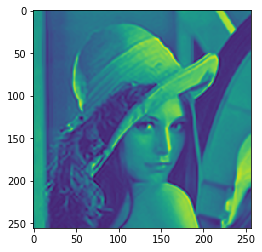

In [190]:
plt.imshow(f[:256,:256])